In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

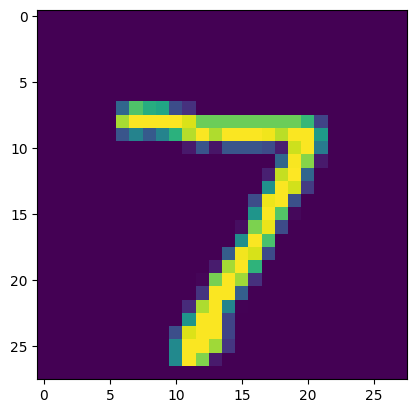

In [3]:
plt.imshow(X_test[0])

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255
X_train.max()

1.0

In [5]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
num_channels = 1

In [6]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, num_channels)
X_test = X_test.reshape(X_test.shape[0], img_width, img_height, num_channels)
X_train.shape

(60000, 28, 28, 1)

In [7]:
input_shape = (img_width, img_height, num_channels)
latent_dim = 2

#VAE with Vanilla Architecture

In [8]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, BatchNormalization
from keras.models import Model
from keras import backend as K

In [9]:
#encoder

input_img = Input(shape=input_shape)
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = (x.shape[1], x.shape[2], x.shape[3])
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name = 'latent_mu')(x)
z_sigma = Dense(latent_dim, name = 'latent_sigma')(x)

def sample_z(args):
    z_mu, z_sigma = args
    eps = tf.random.normal(shape=tf.shape(z_mu))  # Standard normal noise
    return z_mu + tf.exp(0.5 * z_sigma) * eps

z = Lambda(sample_z)([z_mu, z_sigma])

encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder1')
print(encoder.summary())

Model: "encoder1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 2)              │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
#decoder

decoder_input = Input(shape=(latent_dim, ))
print(conv_shape)
x = Dense(conv_shape[0]*conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
x = Reshape((conv_shape[0], conv_shape[1], conv_shape[2]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides = (2,2))(x)
x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x, name='decoder1')
decoder.summary()

(14, 14, 64)


Model: "decoder1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12544)               │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
z_decoded = decoder(z)

In [12]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import binary_crossentropy

class CustomLayer(Layer):
    def __init__(self, kl_weight=5e-4, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.kl_weight = kl_weight

    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = tf.reshape(x, [-1])  # Flatten x
        z_decoded = tf.reshape(z_decoded, [-1])  # Flatten z_decoded

        # Reconstruction Loss
        recon_loss = binary_crossentropy(x, z_decoded)

        # KL Divergence
        kl_loss = -self.kl_weight * tf.reduce_mean(
            1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma)
        )
        return tf.reduce_mean(recon_loss + kl_loss)

    def call(self, inputs):
        x, z_decoded, z_mu, z_sigma = inputs
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss)
        return x


# Assuming `input_img`, `z_decoded`, `z_mu`, and `z_sigma` are defined
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

In [13]:
vae1 = Model(input_img, y, name='vae1')

# Compile VAE
vae1.compile(optimizer='adam', loss=None)
vae1.summary()

Model: "vae1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 2)              │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder1 (Functional)     │ (None, 28, 28, 1)      │         56,385 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_layer              │ (None, 28, 28, 1)      │              0 │ input_layer[0][0],     │
│ (CustomLayer)             │                        │                │ decoder1[0][0],        │
│                           │                        │                │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 550,629 (2.10 MB)

 Trainable params: 550,629 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train autoencoder
history1 = vae1.fit(X_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.2654 - val_loss: 0.2083
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2051 - val_loss: 0.1985
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1964 - val_loss: 0.1930
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1923 - val_loss: 0.1904
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1891 - val_loss: 0.1873
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1868 - val_loss: 0.1864
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1859 - val_loss: 0.1850
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1842 - val_loss: 0.1843
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1828 - val_loss: 0.1841
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1817 - val_loss: 0.1827


In [15]:
y_pred1 = vae1.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


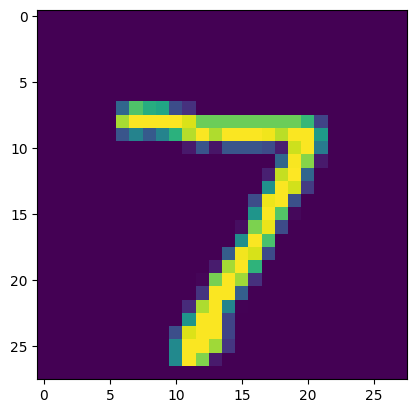

In [16]:
plt.imshow(y_pred1[0])

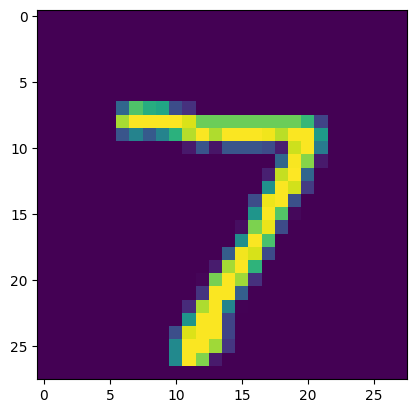

In [17]:
plt.imshow(X_test[0])

#Encoder with encoder-decoder architecture

In [18]:
#encoder

input_img = Input(shape=input_shape)
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(256, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)

conv_shape = (x.shape[1], x.shape[2], x.shape[3])
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name = 'latent_mu2')(x)
z_sigma = Dense(latent_dim, name = 'latent_sigma2')(x)

z = Lambda(sample_z)([z_mu, z_sigma])

encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder2')
print(encoder.summary())

Model: "encoder2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 128)    │         73,856 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 14, 14, 256)    │        295,168 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 14, 14, 128)    │        295,040 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 14, 14, 64)     │         73,792 │ conv2d_transpose_2[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 14, 14, 32)     │         18,464 │ conv2d_transpose_3[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │              0 │ conv2d_transpose_4[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │        200,736 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu2 (Dense)        │ (None, 2)              │             66 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma2 (Dense)     │ (None, 2)              │             66 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 2)              │              0 │ latent_mu2[0][0],      │
│                           │                        │                │ latent_sigma2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 976,004 (3.72 MB)

 Trainable params: 976,004 (3.72 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
#decoder

decoder_input = Input(shape=(latent_dim, ))
print(conv_shape)
x = Dense(conv_shape[0]*conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
x = Reshape((conv_shape[0], conv_shape[1], conv_shape[2]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides = (2,2))(x)
x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x, name='decoder2')
decoder.summary()

(14, 14, 32)


Model: "decoder2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6272)                │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
z_decoded = decoder(z)
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

In [21]:
vae2 = Model(input_img, y, name='vae2')

# Compile VAE
vae2.compile(optimizer='adam', loss=None)
vae2.summary()

Model: "vae2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 128)    │         73,856 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 14, 14, 256)    │        295,168 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 14, 14, 128)    │        295,040 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 14, 14, 64)     │         73,792 │ conv2d_transpose_2[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 14, 14, 32)     │         18,464 │ conv2d_transpose_3[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │              0 │ conv2d_transpose_4[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │        200,736 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu2 (Dense)        │ (None, 2)              │             66 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma2 (Dense)     │ (None, 2)              │             66 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 2)              │              0 │ latent_mu2[0][0],      │
│                           │                        │                │ latent_sigma2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder2 (Functional)     │ (None, 28, 28, 1)      │         28,353 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_layer_1            │ (None, 28, 28, 1)      │              0 │ input_layer_2[0][0],   │
│ (CustomLayer)             │                        │                │ decoder2[0][0],        │
│                           │                        │                │ latent_mu2[0][0],      │
│                           │                        │                │ latent_sigma2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,004,357 (3.83 MB)

 Trainable params: 1,004,357 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history2 = vae2.fit(X_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.6007 - val_loss: 0.2098
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.2078 - val_loss: 0.2014
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.1997 - val_loss: 0.1973
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1950 - val_loss: 0.1932
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.1930 - val_loss: 0.1911
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1909 - val_loss: 0.1898
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1899 - val_loss: 0.1879
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.1896 - val_loss: 0.1880
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.1879 - val_loss: 0.1885
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.1869 - val_loss: 0.1857


In [23]:
y_pred2 = vae2.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


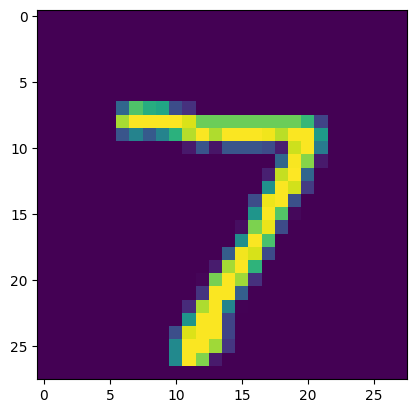

In [24]:
plt.imshow(y_pred2[0])

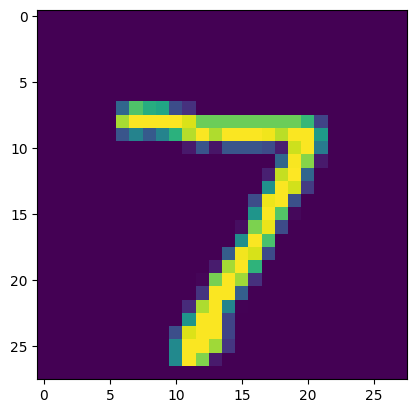

In [25]:
plt.imshow(X_test[0])

#Decoder with encoder-decoder architecture

In [26]:
#encoder

input_img = Input(shape=input_shape)
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = (x.shape[1], x.shape[2], x.shape[3])
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name = 'latent_mu3')(x)
z_sigma = Dense(latent_dim, name = 'latent_sigma3')(x)

z = Lambda(sample_z)([z_mu, z_sigma])

encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder3')
print(encoder.summary())

Model: "encoder3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 12544)          │              0 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │        401,440 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu3 (Dense)        │ (None, 2)              │             66 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma3 (Dense)     │ (None, 2)              │             66 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 2)              │              0 │ latent_mu3[0][0],      │
│                           │                        │                │ latent_sigma3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 457,316 (1.74 MB)

 Trainable params: 457,316 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
#decoder

decoder_input = Input(shape=(latent_dim, ))
print(conv_shape)
x = Dense(conv_shape[0]*conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
x = Reshape((conv_shape[0], conv_shape[1], conv_shape[2]))(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(256, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides = (2,2))(x)
x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x, name='decoder3')
decoder.summary()

(14, 14, 64)


Model: "decoder3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12544)               │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 14, 14, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 28, 28, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 794,241 (3.03 MB)

 Trainable params: 794,241 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
z_decoded = decoder(z)
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

In [29]:
vae3 = Model(input_img, y, name='vae3')

# Compile VAE
vae3.compile(optimizer='adam', loss=None)
vae3.summary()

Model: "vae3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 12544)          │              0 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │        401,440 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu3 (Dense)        │ (None, 2)              │             66 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma3 (Dense)     │ (None, 2)              │             66 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 2)              │              0 │ latent_mu3[0][0],      │
│                           │                        │                │ latent_sigma3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder3 (Functional)     │ (None, 28, 28, 1)      │        794,241 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_layer_2            │ (None, 28, 28, 1)      │              0 │ input_layer_4[0][0],   │
│ (CustomLayer)             │                        │                │ decoder3[0][0],        │
│                           │                        │                │ latent_mu3[0][0],      │
│                           │                        │                │ latent_sigma3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,251,557 (4.77 MB)

 Trainable params: 1,251,557 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history3 = vae3.fit(X_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.2548 - val_loss: 0.1974
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.1959 - val_loss: 0.1914
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.1913 - val_loss: 0.1883
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1883 - val_loss: 0.1881
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1868 - val_loss: 0.1857
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1855 - val_loss: 0.1847
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.1844 - val_loss: 0.1833
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.1832 - val_loss: 0.1834
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.1820 - val_loss: 0.1827
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.1816 - val_loss: 0.1838


In [31]:
y_pred3 = vae3.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


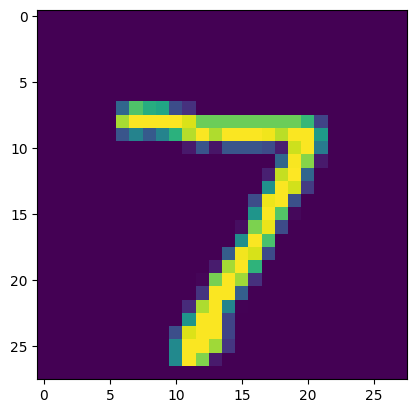

In [32]:
plt.imshow(y_pred3[0])

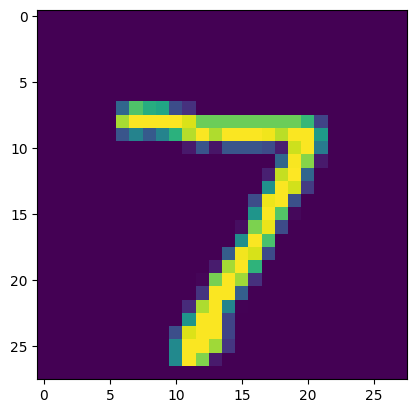

In [33]:
plt.imshow(X_test[0])

#Both are replaced with encoder-decoder architecture

In [34]:
#encoder

input_img = Input(shape=input_shape)
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(256, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)

conv_shape = (x.shape[1], x.shape[2], x.shape[3])
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name = 'latent_mu2')(x)
z_sigma = Dense(latent_dim, name = 'latent_sigma2')(x)

z = Lambda(sample_z)([z_mu, z_sigma])

encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder4')
print(encoder.summary())

Model: "encoder4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 14, 14, 128)    │         73,856 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 14, 14, 256)    │        295,168 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_11       │ (None, 14, 14, 128)    │        295,040 │ conv2d_16[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_12       │ (None, 14, 14, 64)     │         73,792 │ conv2d_transpose_11[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 12544)          │              0 │ conv2d_transpose_12[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │        401,440 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu2 (Dense)        │ (None, 2)              │             66 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma2 (Dense)     │ (None, 2)              │             66 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 2)              │              0 │ latent_mu2[0][0],      │
│                           │                        │                │ latent_sigma2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,158,244 (4.42 MB)

 Trainable params: 1,158,244 (4.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
#decoder

decoder_input = Input(shape=(latent_dim, ))
print(conv_shape)
x = Dense(conv_shape[0]*conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
x = Reshape((conv_shape[0], conv_shape[1], conv_shape[2]))(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(256, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides = (2,2))(x)
x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x, name='decoder4')
decoder.summary()

(14, 14, 64)


Model: "decoder4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12544)               │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 14, 14, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 14, 14, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 28, 28, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 28, 28, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 794,241 (3.03 MB)

 Trainable params: 794,241 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
z_decoded = decoder(z)
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

In [37]:
vae4 = Model(input_img, y, name='vae4')

# Compile VAE
vae4.compile(optimizer='adam', loss=None)
vae4.summary()

Model: "vae4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 14, 14, 128)    │         73,856 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 14, 14, 256)    │        295,168 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_11       │ (None, 14, 14, 128)    │        295,040 │ conv2d_16[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_12       │ (None, 14, 14, 64)     │         73,792 │ conv2d_transpose_11[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 12544)          │              0 │ conv2d_transpose_12[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │        401,440 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu2 (Dense)        │ (None, 2)              │             66 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma2 (Dense)     │ (None, 2)              │             66 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 2)              │              0 │ latent_mu2[0][0],      │
│                           │                        │                │ latent_sigma2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder4 (Functional)     │ (None, 28, 28, 1)      │        794,241 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_layer_3            │ (None, 28, 28, 1)      │              0 │ input_layer_6[0][0],   │
│ (CustomLayer)             │                        │                │ decoder4[0][0],        │
│                           │                        │                │ latent_mu2[0][0],      │
│                           │                        │                │ latent_sigma2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,952,485 (7.45 MB)

 Trainable params: 1,952,485 (7.45 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history4 = vae4.fit(X_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 0.2810 - val_loss: 0.2344
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - loss: 0.2332 - val_loss: 0.2222
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - loss: 0.2213 - val_loss: 0.2159
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.2163 - val_loss: 0.2109
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 0.2129 - val_loss: 0.2079
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.2101 - val_loss: 0.2061
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.2077 - val_loss: 0.2048
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.2062 - val_loss: 0.2053
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.2044 - val_loss: 0.2060
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.2042 - val_loss: 0.2078


In [39]:
y_pred4 = vae4.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


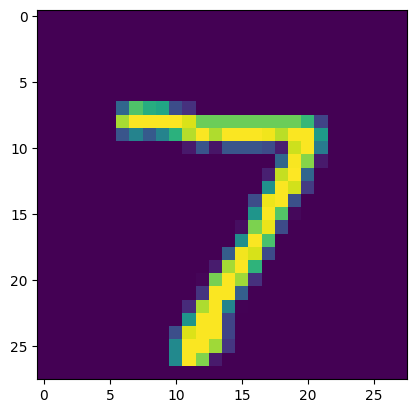

In [40]:
plt.imshow(y_pred4[0])

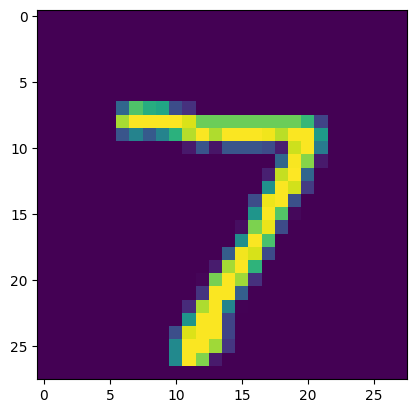

In [41]:
plt.imshow(X_test[0])

#Comparing Histories

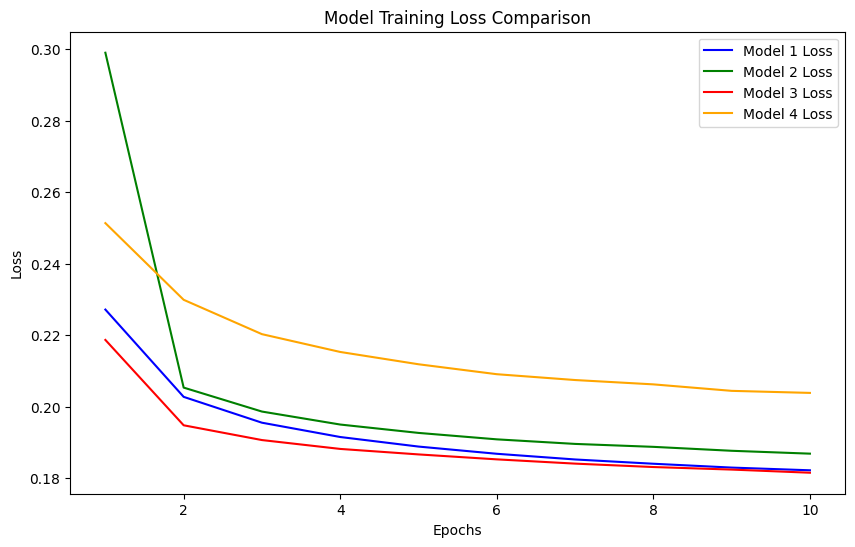

In [42]:
# Extract the loss (or other metric) for each model
loss_1 = history1.history['loss']
loss_2 = history2.history['loss']
loss_3 = history3.history['loss']
loss_4 = history4.history['loss']

# Define the number of epochs
epochs = range(1, len(loss_1) + 1)

# Plotting the loss for each model
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_1, label="Model 1 Loss", color='blue')
plt.plot(epochs, loss_2, label="Model 2 Loss", color='green')
plt.plot(epochs, loss_3, label="Model 3 Loss", color='red')
plt.plot(epochs, loss_4, label="Model 4 Loss", color='orange')

# Adding labels and title
plt.title("Model Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display the plot
plt.show()

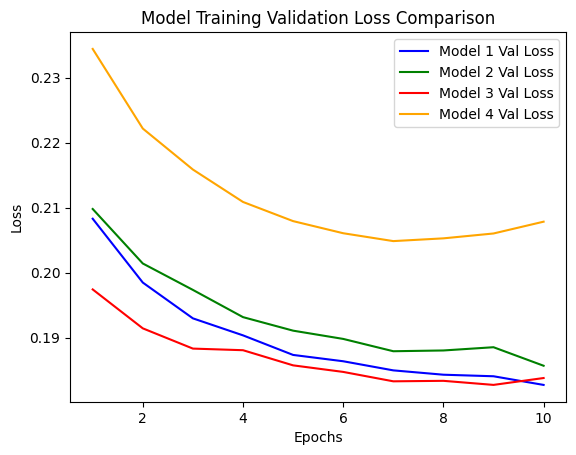

In [43]:
val_loss_1 = history1.history['val_loss']
val_loss_2 = history2.history['val_loss']
val_loss_3 = history3.history['val_loss']
val_loss_4 = history4.history['val_loss']

# Define the number of epochs
epochs = range(1, len(val_loss_1) + 1)

plt.plot(epochs, val_loss_1, label="Model 1 Val Loss", color='blue')
plt.plot(epochs, val_loss_2, label="Model 2 Val Loss", color='green')
plt.plot(epochs, val_loss_3, label="Model 3 Val Loss", color='red')
plt.plot(epochs, val_loss_4, label="Model 4 Val Loss", color='orange')

# Adding labels and title
plt.title("Model Training Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display the plot
plt.show()

\begin{array}{|c|c|c|c|}
\hline
\textbf{Model} & \textbf{Approx Time Taken (min)} & \textbf{Loss (Last Epoch)} & \textbf{Validation Loss (Last Epoch)} \\
\hline
\text{Model 1} & \text{1} & \text{0.1817} & \text{0.1827} \\
\text{Model 2} & \text{2} & \text{0.1869} & \text{0.1857} \\
\text{Model 3} & \text{3} & \text{0.1816} & \text{0.1838} \\
\text{Model 4} & \text{6} & \text{0.2042} & \text{0.2078} \\
\hline
\end{array}



We can see that Model 1 and Model 3 performs almost similarly with Model 3 being a lil better and Model 4 has worst performance here